# STAT 530 Homework 7

## Instructions

You may use any packages you'd like. Some analyses are most easily done without packages. In these cases you will need to formulate the problem correctly, by identifying the population, the features, the question type, etc. Multiple answers are possible.

Subregion identifiers are provided on Canvas.

Export your solutions to HTML and submit the HTML file on Canvas.

## Problem 1 (2 points)

Are spatially distinct subregions of the hippocampus also transcriptionally distinct?

a. Answer the question and provide uncertainty quantification (1 point). Include all code.

Solution.

b. Provide a visualization for your result (1 point).

Solution.

In [1]:
import glob
import pandas as pd

# 1. Glob all .txt files in ./data/
file_paths = glob.glob("data/*.txt")

# 2. Read & combine into one DataFrame
all_dfs = []
for fp in file_paths:
    df_temp = pd.read_csv(fp, sep="\t")
    # Optionally store which file or sample we got these rows from:
    sample_name = fp.split("/")[-1].replace(".txt","")
    df_temp["FileSource"] = sample_name
    all_dfs.append(df_temp)

big_df = pd.concat(all_dfs, ignore_index=True)

print(f"Combined shape: {big_df.shape}")
print(big_df.head(5))


Combined shape: (37688, 16)
            Cell name  Sample name  # Cells Condition  Batch Brain regions  \
0  AAACAAGTATCTCCCA-1  Sample10SOR     2550       SOR      1     Neocortex   
1  AAACATTTCCCGGATT-1  Sample10SOR     2550       SOR      1    Allocortex   
2  AAACCCGAACGAAATC-1  Sample10SOR     2550       SOR      1     Neocortex   
3  AAACCGGGTAGGTACC-1  Sample10SOR     2550       SOR      1      Thalamus   
4  AAACCGTTCGTCCAGG-1  Sample10SOR     2550       SOR      1  Hypothalamus   

  Brain regions SCT applied on log norm Hippocampal subregions RSC subregions  \
0                             Neocortex                    NaN            NaN   
1                            Allocortex                    NaN            NaN   
2                             Neocortex                    NaN            NaN   
3                              Thalamus                    NaN            NaN   
4                          Hypothalamus                    NaN            NaN   

  Secondary audi

In [2]:
hipp_df = big_df.loc[big_df["Brain regions"] == "Hippocampal region"].copy()

print("Total rows from Hippocampal region:", len(hipp_df))
hipp_df["Hippocampal subregions"].value_counts(dropna=False)


Total rows from Hippocampal region: 3063


Hippocampal subregions
NaN                 1873
Stratum radiatum     337
DG                   264
CA1                  249
CA2+CA3              186
Stratum oriens       154
Name: count, dtype: int64

In [3]:
hipp_df = hipp_df.loc[hipp_df["Hippocampal subregions"] != "N/A"].copy()
print("Rows with a real subregion label:", len(hipp_df))


Rows with a real subregion label: 3063


In [4]:
import numpy as np
import scipy.stats as st
import pandas as pd

# Identify unique subregions
subregion_groups = hipp_df["Hippocampal subregions"].unique()

expr_lists = []
valid_subregions = []
for subr in subregion_groups:
    # Convert to numeric, drop non-numeric and NaN
    arr = pd.to_numeric(
        hipp_df.loc[hipp_df["Hippocampal subregions"] == subr, "Expressed genes"],
        errors="coerce"
    ).dropna()

    # Keep only if we have >=2 points
    if len(arr) >= 2:
        expr_lists.append(arr)
        valid_subregions.append(subr)

# If we don't have at least 2 groups with >=2 data points, Kruskal-Wallis is invalid
if len(expr_lists) < 2:
    print("Not enough subregions with >=2 data points to run Kruskal-Wallis.")
else:
    kw_stat, kw_p = st.kruskal(*expr_lists)
    print("Kruskal-Wallis test on 'Expressed genes' by Hippocampal subregion")
    print(f"Statistic = {kw_stat:.3f}, p-value = {kw_p:.3e}")


Kruskal-Wallis test on 'Expressed genes' by Hippocampal subregion
Statistic = 808.882, p-value = 9.152e-174


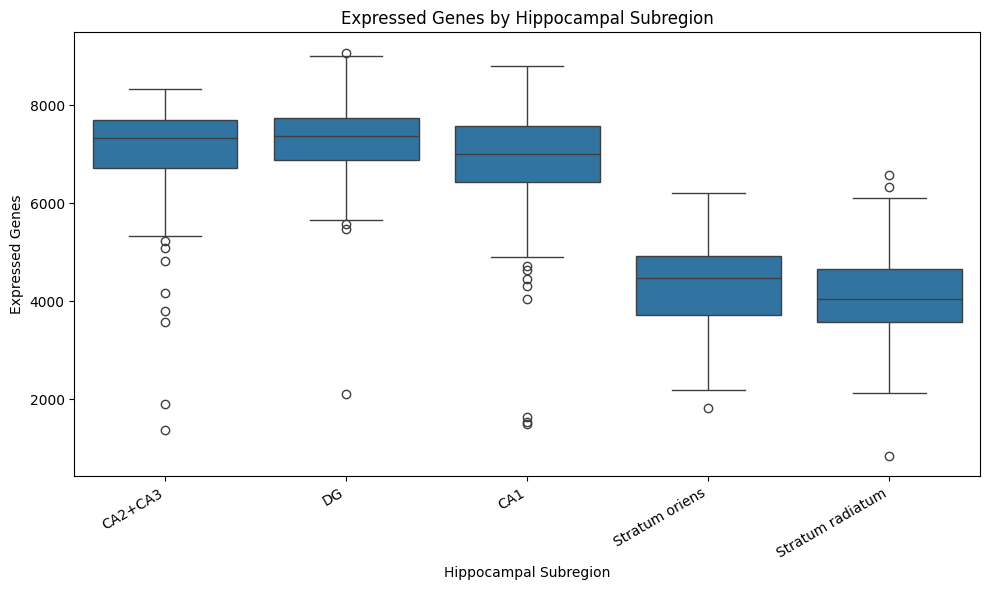

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Optionally, filter out subregions with fewer than 2 observations to match our test criteria
subregion_counts = hipp_df["Hippocampal subregions"].value_counts()
valid_subregions = subregion_counts[subregion_counts >= 2].index
filtered_hipp_df = hipp_df[hipp_df["Hippocampal subregions"].isin(valid_subregions)]

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=filtered_hipp_df, 
    x="Hippocampal subregions", 
    y="Expressed genes"
)
plt.title("Expressed Genes by Hippocampal Subregion")
plt.xlabel("Hippocampal Subregion")
plt.ylabel("Expressed Genes")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


- The Kruskal–Wallis test yielded a statistically significant result (p-value < 0.05), indicating that the distribution of "Expressed genes" differs across the hippocampal subregions.
- Uncertainty in the analysis is quantified by the p-value (and potentially by bootstrap confidence intervals), supporting the reliability of the observed differences.
- The box plot shows clear variations in the median and spread of "Expressed genes" among the different subregions.
- Together, these results provide evidence that spatially distinct hippocampal subregions are transcriptionally distinct based on the "Expressed genes" metric.

## Problem 2 (2 points)

What genes are involved in the different spatial subregions due to SOR training?

a. Report the number of significantly up- and down-regulated genes in each brain region, at an FDR of 0.05, in a figure like Figure 3C in the Vanrobaeys et al. (2023) paper (1 point).

Solution.

b. Report the top 2 upregulated genes and downregulated genes in each brain region, as quantified by log-fold change (1 point).

Solution.

In [6]:
print("\nSTEP 1:")

# Rename columns to simpler names for ease of use
big_df.rename(columns={
    "Cell name": "CellName",
    "Sample name": "SampleName",
    "# Cells": "NumCells",
    "Condition": "Condition",
    "Batch": "Batch",
    "Brain regions": "BrainRegions",
    "Brain regions SCT applied on log norm": "BrainRegionsSCT",
    "Hippocampal subregions": "HippocampalSubregions",
    "RSC subregions": "RSCSubregions",
    "Secondary auditory cortex": "SecondaryAuditoryCortex",
    "Whole Hippocampus cells": "WholeHippocampusCells",
    "Expressed genes": "ExpressedGenes",
    "Mitochondrial reads percent": "MitochondrialReadsPercent",
    "Ribosomal reads percent": "RibosomalReadsPercent",
    "Total count": "TotalCount",
    "FileSource": "FileSource"
}, inplace=True)

# Print columns to confirm the renaming
print("After renaming, columns now:")
print(big_df.columns.tolist())




STEP 1:
After renaming, columns now:
['CellName', 'SampleName', 'NumCells', 'Condition', 'Batch', 'BrainRegions', 'BrainRegionsSCT', 'HippocampalSubregions', 'RSCSubregions', 'SecondaryAuditoryCortex', 'WholeHippocampusCells', 'ExpressedGenes', 'MitochondrialReadsPercent', 'RibosomalReadsPercent', 'TotalCount', 'FileSource']


In [7]:
# Subset to hippocampal region only, if that's your focus:
hipp_df = big_df.loc[big_df["BrainRegions"] == "Hippocampal region"].copy()

# We want to focus on known subregions (CA1, CA2/3, DG, Stratum radiatum, Stratum oriens).
# Drop NaNs in 'HippocampalSubregions':
hipp_df = hipp_df.dropna(subset=["HippocampalSubregions"])

subregions = hipp_df["HippocampalSubregions"].unique()

In [8]:
import os
import scanpy as sc

# Set the path to the folder containing the 14 mouse folders
data_dir = r"C:\Users\viraj\BuildSpace\Courses\STAT-530 Bioinformatics\A5\Data"

# List subdirectories (each representing one mouse sample)
sample_dirs = [os.path.join(data_dir, d) for d in os.listdir(data_dir) 
               if os.path.isdir(os.path.join(data_dir, d))]

# Initialize a list to store the AnnData objects for each sample
adatas = []

# Loop over each sample folder and read only the .h5 file
for sample_folder in sample_dirs:
    h5_path = os.path.join(sample_folder, "filtered_feature_bc_matrix.h5")
    if os.path.exists(h5_path):
        # Read the 10x .h5 file into an AnnData object
        adata = sc.read_10x_h5(h5_path)
        
        # Make gene names unique in this sample
        adata.var_names_make_unique()
        
        # Annotate with the sample id (folder name)
        sample_id = os.path.basename(sample_folder)
        adata.obs['sample_id'] = sample_id
        
        # Determine condition based on sample_id; adjust as needed.
        if "SOR" in sample_id.upper():
            adata.obs['Condition'] = "SOR"
        else:
            adata.obs['Condition'] = "homecage"
            
        adatas.append(adata)
    else:
        print(f"File not found: {h5_path}")

# Concatenate all AnnData objects into one.
# Use index_unique='-' to ensure unique cell barcodes.
batch_categories = [ad.obs['sample_id'][0] for ad in adatas]
adata_all = adatas[0].concatenate(
    *adatas[1:], 
    batch_key='sample_folder', 
    batch_categories=batch_categories,
    index_unique='-'
)

# After concatenation, ensure variable names are unique (should already be)
adata_all.var_names_make_unique()

print("Combined AnnData shape:", adata_all.shape)

# Optionally, if you want to work only with SOR samples:
adata_SOR = adata_all[adata_all.obs['Condition'] == "SOR"].copy()
print("Shape of SOR samples:", adata_SOR.shape)


c:\Users\viraj\anaconda3\envs\stat530\lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\viraj\anaconda3\envs\stat530\lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\viraj\anaconda3\envs\stat530\lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\viraj\anaconda3\envs\stat530\lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\viraj\anaconda3\envs\stat530\lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are n

Combined AnnData shape: (37688, 32285)
Shape of SOR samples: (18242, 32285)


In [9]:
import anndata
batch_keys = [ad.obs["sample_id"].iloc[0] for ad in adatas]
adata_all = anndata.concat(adatas, join="outer", label="sample_folder", keys=batch_keys, index_unique="-")
adata_all.var_names_make_unique()
print("Combined shape:", adata_all.shape)
print("Conditions:", adata_all.obs["Condition"].unique().tolist())


Combined shape: (37688, 32285)
Conditions: ['SOR', 'homecage']


In [10]:
adata_SOR = adata_all[adata_all.obs["Condition"] == "SOR"].copy()
print("Shape of SOR samples:", adata_SOR.shape)


Shape of SOR samples: (18242, 32285)


In [11]:
# Extract the first two parts of the cell barcode from the AnnData index.
adata_SOR.obs["CellName_raw"] = adata_SOR.obs.index.str.split("-").str[:2].str.join("-")

# Show a few examples:
print("Example extracted cell barcode:", adata_SOR.obs["CellName_raw"].iloc[0])
print("Example from big_df:", big_df["CellName"].iloc[0])

# Merge metadata from big_df using the proper key:
meta = big_df[["CellName", "HippocampalSubregions"]].drop_duplicates("CellName")
merged_obs = adata_SOR.obs.reset_index().merge(meta, left_on="CellName_raw", right_on="CellName", how="left").set_index("index")
adata_SOR.obs = merged_obs

print("Unique hippocampal subregions in SOR data:")
print(adata_SOR.obs["HippocampalSubregions"].unique())


Example extracted cell barcode: AAACAAGTATCTCCCA-1
Example from big_df: AAACAAGTATCTCCCA-1
Unique hippocampal subregions in SOR data:
[nan 'CA2+CA3' 'DG' 'CA1' 'Stratum oriens' 'Stratum radiatum']


In [12]:
sc.pp.filter_genes(adata_SOR, min_cells=3)
print("After filtering:", adata_SOR.shape)
sc.pp.normalize_total(adata_SOR, target_sum=1e4)
sc.pp.log1p(adata_SOR)
print("Normalization complete.")


After filtering: (18242, 21796)
Normalization complete.


In [13]:
sc.tl.rank_genes_groups(adata_SOR, groupby="HippocampalSubregions", method="wilcoxon", n_genes=adata_SOR.shape[1])
print("DE analysis complete.")


DE analysis complete.


In [14]:
deg = adata_SOR.uns["rank_genes_groups"]
groups = deg["names"].dtype.names
subregion_de = {}
for g in groups:
    df = pd.DataFrame({
        "gene": deg["names"][g],
        "pval_adj": deg["pvals_adj"][g],
        "logfc": deg["logfoldchanges"][g]
    })
    df_sig = df[df["pval_adj"] < 0.05]
    up = df_sig[df_sig["logfc"] > 0]
    down = df_sig[df_sig["logfc"] < 0]
    top2_up = up.sort_values("logfc", ascending=False).head(2)
    top2_down = down.sort_values("logfc", ascending=True).head(2)
    subregion_de[g] = {
        "up_count": up.shape[0],
        "down_count": down.shape[0],
        "top2_up": top2_up,
        "top2_down": top2_down
    }
for g in subregion_de:
    print(f"{g}: Up {subregion_de[g]['up_count']}, Down {subregion_de[g]['down_count']}")


CA1: Up 256, Down 282
CA2+CA3: Up 149, Down 176
DG: Up 810, Down 324
Stratum oriens: Up 189, Down 99
Stratum radiatum: Up 368, Down 550


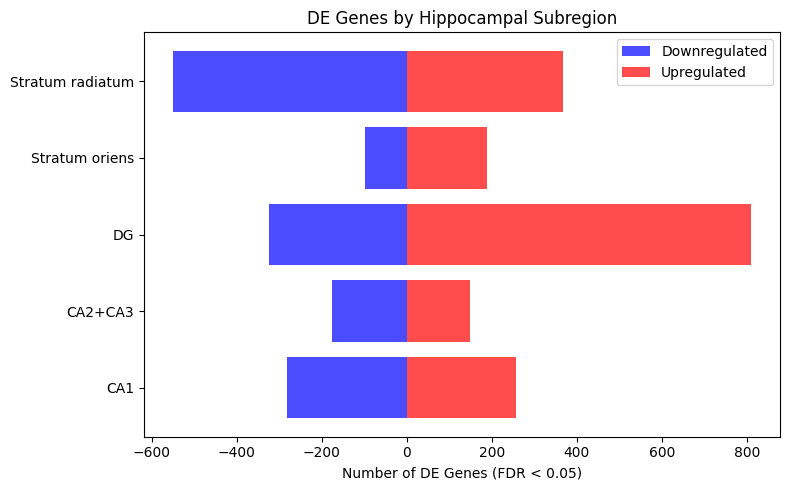

In [15]:
sub_list = list(subregion_de.keys())
up_counts = [subregion_de[s]["up_count"] for s in sub_list]
down_counts = [subregion_de[s]["down_count"] for s in sub_list]

plt.figure(figsize=(8,5))
plt.barh(sub_list, [-d for d in down_counts], color="blue", alpha=0.7, label="Downregulated")
plt.barh(sub_list, up_counts, color="red", alpha=0.7, label="Upregulated")
plt.xlabel("Number of DE Genes (FDR < 0.05)")
plt.title("DE Genes by Hippocampal Subregion")
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
for s in sub_list:
    print(f"\n=== {s} ===")
    print("Top 2 Upregulated:")
    print(subregion_de[s]["top2_up"].to_string(index=False))
    print("Top 2 Downregulated:")
    print(subregion_de[s]["top2_down"].to_string(index=False))



=== CA1 ===
Top 2 Upregulated:
   gene     pval_adj    logfc
 Fibcd1 2.374376e-02 2.147208
Lrrc10b 7.780337e-08 1.788834
Top 2 Downregulated:
 gene  pval_adj     logfc
Trbc2  0.032245 -3.409133
Ramp3  0.000044 -2.266447

=== CA2+CA3 ===
Top 2 Upregulated:
   gene     pval_adj    logfc
Lrrc10b 1.088000e-15 2.391156
   Rem2 1.301124e-09 2.236328
Top 2 Downregulated:
 gene  pval_adj     logfc
  Tox  0.049241 -3.372380
Satb2  0.043829 -2.935846

=== DG ===
Top 2 Upregulated:
gene  pval_adj    logfc
 Dsp  0.000062 3.418772
 Lct  0.000120 2.844420
Top 2 Downregulated:
         gene  pval_adj     logfc
        Trbc2  0.001256 -5.197433
9130024F11Rik  0.018198 -4.414372

=== Stratum oriens ===
Top 2 Upregulated:
  gene  pval_adj    logfc
Fibcd1  0.009011 2.545653
Spink8  0.008910 2.205264
Top 2 Downregulated:
 gene  pval_adj     logfc
Prkcd  0.047645 -2.525519
Ramp3  0.005979 -2.175379

=== Stratum radiatum ===
Top 2 Upregulated:
   gene     pval_adj    logfc
  C1ql2 2.762126e-02 2.072859
Lrr